In [36]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams.update({'font.size': 16})
import qiskit.tools.jupyter
from qiskit import QuantumCircuit, QuantumRegister, IBMQ, execute, transpile
from qiskit.providers.aer import QasmSimulator
from qiskit.tools.monitor import job_monitor
from qiskit.circuit import Parameter
from qiskit.opflow import Zero, One, X, Y, Z, I
import qiskit.ignis.mitigation.measurement as mc
import qiskit.ignis.verification.tomography as tomo
from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter
from qiskit.quantum_info import state_fidelity

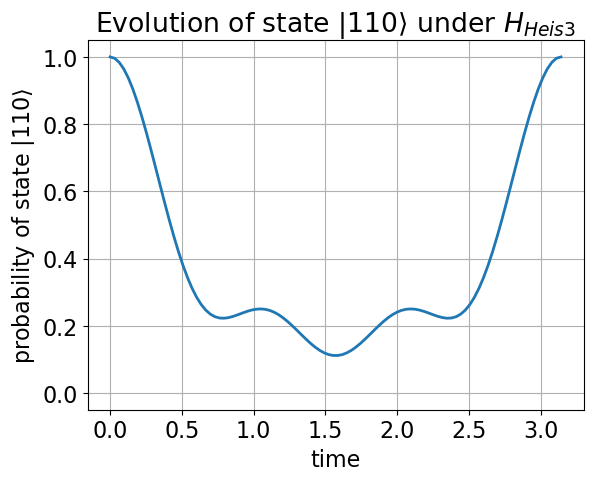

In [31]:
H=(I^X^X) + (X^X^I)+(I^Y^Y) + (Y^Y^I) +(I^Z^Z)+(Z^Z^I)
ts = np.linspace(0, np.pi, 100)
initial_state = One^One^Zero
def time_evolution_operator(t):
    U=(t*H).exp_i()
    return U
prob = [np.abs(((~initial_state @ time_evolution_operator(float(t)) @ initial_state).eval())**2) for t in ts]
plt.plot(ts, prob, linewidth=2)
plt.xlabel('time')
plt.ylabel(r'probability of state $|110\rangle$')
plt.title(r'Evolution of state $|110\rangle$ under $H_{Heis3}$')
plt.ylim([-0.05,1.05])
plt.grid()
plt.show()

In [18]:
IBMQ.save_account('679707cbb8f517c35005fa61cd11b412788a070df411694da9df69f9675f9c98a5af79fb5f73409dcf2dddf6bc3c256ed90d38b4d6225e59bfaad57e9f065f1f')  
provider = IBMQ.load_account()

In [21]:
provider = IBMQ.get_provider(hub='ibm-q')
manila = provider.get_backend('ibmq_manila')
sim_noisy_manila = QasmSimulator.from_backend(provider.get_backend('ibmq_manila'))

sim = QasmSimulator()

In [23]:
t = Parameter('t')
def compute_XX_gate(t):
    XX_qr = QuantumRegister(2)
    XX_qc = QuantumCircuit(XX_qr, name='XX')

    XX_qc.ry(np.pi/2,[0,1])
    XX_qc.cnot(0,1)
    XX_qc.rz(2 * t, 1)
    XX_qc.cnot(0,1)
    XX_qc.ry(-np.pi/2,[0,1])
    XX = XX_qc.to_instruction()
    
    return XX

def compute_YY_gate(t):
    YY_qr = QuantumRegister(2)
    YY_qc = QuantumCircuit(YY_qr, name='YY')

    YY_qc.rx(np.pi/2,[0,1])
    YY_qc.cnot(0,1)
    YY_qc.rz(2 * t, 1)
    YY_qc.cnot(0,1)
    YY_qc.rx(-np.pi/2,[0,1])
    YY = YY_qc.to_instruction()

    
    return YY

def compute_ZZ_gate(t):
    ZZ_qr = QuantumRegister(2)
    ZZ_qc = QuantumCircuit(ZZ_qr, name='ZZ')

    ZZ_qc.cnot(0,1)
    ZZ_qc.rz(2 * t, 1)
    ZZ_qc.cnot(0,1)
    ZZ = ZZ_qc.to_instruction()
    
    return ZZ



In [24]:
num_qubits = 3

XX = compute_XX_gate(t)
YY = compute_YY_gate(t)
ZZ = compute_ZZ_gate(t)

Trot_qr = QuantumRegister(num_qubits)
Trot_qc = QuantumCircuit(Trot_qr, name='Trot')

for i in range(0, num_qubits - 1):
    Trot_qc.append(ZZ, [Trot_qr[i], Trot_qr[i+1]])
    Trot_qc.append(YY, [Trot_qr[i], Trot_qr[i+1]])
    Trot_qc.append(XX, [Trot_qr[i], Trot_qr[i+1]])

Trot_gate = Trot_qc.to_instruction()

In [32]:
target_time = np.pi 
trotter_steps = 4  
q_regs = [0,1,2]

qr = QuantumRegister(5)
qc = QuantumCircuit(qr)


qc.x([q_regs[2], q_regs[1]]) 


for _ in range(trotter_steps):
    qc.append(Trot_gate, q_regs)


qc = qc.bind_parameters({t: target_time/trotter_steps})

st_qcs = state_tomography_circuits(qc, q_regs)
qr = QuantumRegister(5)
qc = QuantumCircuit(qr)


st_qcs[-1].decompose().draw()  


┌──────────┐┌──────────┐┌──────────┐            »
q10_0: ─────────────┤0         ├┤0         ├┤0         ├────────────»
       ┌───────────┐│  ZZ(π/4) ││  YY(π/4) ││  XX(π/4) │┌──────────┐»
q10_1: ┤ U3(π,0,π) ├┤1         ├┤1         ├┤1         ├┤0         ├»
       ├───────────┤└──────────┘└──────────┘└──────────┘│  ZZ(π/4) │»
q10_2: ┤ U3(π,0,π) ├────────────────────────────────────┤1         ├»
       └───────────┘                                    └──────────┘»
q10_3: ─────────────────────────────────────────────────────────────»
                                                                    »
q10_4: ─────────────────────────────────────────────────────────────»
                                                                    »
 c3: 3/═════════════════════════════════════════════════════════════»
                                                                    »
«                               ┌──────────┐┌──────────┐┌──────────┐»
«q10_0: ────────────────────────┤0         ├┤0         ├┤0         ├»
«       ┌──────────┐┌──────────┐│  ZZ(π/4) ││  YY(π/4) ││  XX(π/4) │»
«q10_1: ┤0         ├┤0         ├┤1         ├┤1         ├┤1         ├»
«       │  YY(π/4) ││  XX(π/4) │└──────────┘└──────────┘└──────────┘»
«q10_2: ┤1         ├┤1         ├────────────────────────────────────»
«       └──────────┘└──────────┘                                    »
«q10_3: ────────────────────────────────────────────────────────────»
«                                                                   »
«q10_4: ────────────────────────────────────────────────────────────»
«                                                                   »
« c3: 3/════════════════════════════════════════════════════════════»
«                                                                   »
«                                           ┌──────────┐┌──────────┐»
«q10_0: ────────────────────────────────────┤0         ├┤0         ├»
«       ┌──────────┐┌──────────┐┌──────────┐│  ZZ(π/4) ││  YY(π/4) │»
«q10_1: ┤0         ├┤0         ├┤0         ├┤1         ├┤1         ├»
«       │  ZZ(π/4) ││  YY(π/4) ││  XX(π/4) │└──────────┘└──────────┘»
«q10_2: ┤1         ├┤1         ├┤1         ├────────────────────────»
«       └──────────┘└──────────┘└──────────┘                        »
«q10_3: ────────────────────────────────────────────────────────────»
«                                                                   »
«q10_4: ────────────────────────────────────────────────────────────»
«                                                                   »
« c3: 3/════════════════════════════════════════════════════════════»
«                                                                   »
«       ┌──────────┐                                    ┌──────────┐»
«q10_0: ┤0         ├────────────────────────────────────┤0         ├»
«       │  XX(π/4) │┌──────────┐┌──────────┐┌──────────┐│  ZZ(π/4) │»
«q10_1: ┤1         ├┤0         ├┤0         ├┤0         ├┤1         ├»
«       └──────────┘│  ZZ(π/4) ││  YY(π/4) ││  XX(π/4) │└──────────┘»
«q10_2: ────────────┤1         ├┤1         ├┤1         ├────────────»
«                   └──────────┘└──────────┘└──────────┘            »
«q10_3: ────────────────────────────────────────────────────────────»
«                                                                   »
«q10_4: ────────────────────────────────────────────────────────────»
«                                                                   »
« c3: 3/════════════════════════════════════════════════════════════»
«                                                                   »
«       ┌──────────┐┌──────────┐                                     ░ ┌─┐   »
«q10_0: ┤0         ├┤0         ├─────────────────────────────────────░─┤M├───»
«       │  YY(π/4) ││  XX(π/4) │┌──────────┐┌──────────┐┌──────────┐ ░ └╥┘┌─┐»
«q10_1: ┤1         ├┤1         ├┤0         ├┤0         ├┤0         ├─░──╫─┤M├»
«       └──────────┘└──────────┘│  ZZ(π/4) ││  YY(π/4) ││  XX(π/

In [33]:
st_qcs[-1].draw()  

┌────────────┐┌────────────┐┌────────────┐┌────────────┐ ░ ┌─┐   »
q10_0: ─────┤0           ├┤0           ├┤0           ├┤0           ├─░─┤M├───»
       ┌───┐│            ││            ││            ││            │ ░ └╥┘┌─┐»
q10_1: ┤ X ├┤1 Trot(π/4) ├┤1 Trot(π/4) ├┤1 Trot(π/4) ├┤1 Trot(π/4) ├─░──╫─┤M├»
       ├───┤│            ││            ││            ││            │ ░  ║ └╥┘»
q10_2: ┤ X ├┤2           ├┤2           ├┤2           ├┤2           ├─░──╫──╫─»
       └───┘└────────────┘└────────────┘└────────────┘└────────────┘ ░  ║  ║ »
q10_3: ──────────────────────────────────────────────────────────────░──╫──╫─»
                                                                     ░  ║  ║ »
q10_4: ──────────────────────────────────────────────────────────────░──╫──╫─»
                                                                     ░  ║  ║ »
 c3: 3/═════════════════════════════════════════════════════════════════╩══╩═»
                                                                        0  1 »
«          
«q10_0: ───
«          
«q10_1: ───
«       ┌─┐
«q10_2: ┤M├
«       └╥┘
«q10_3: ─╫─
«        ║ 
«q10_4: ─╫─
«        ║ 
« c3: 3/═╩═
«        2

In [34]:
shots = 8192
reps = 4

backend = sim  
jobs = []
for _ in range(reps):
    job = execute(st_qcs, backend, shots=shots)
    print('Job ID', job.job_id())
    jobs.append(job)
    
for job in jobs:
    job_monitor(job)
    try:
        if job.error_message() is not None:
            print(job.error_message())
    except:
        pass

Job ID 18133d05-9797-442f-ade1-05098ffdf9d5
Job ID 4449def9-1bc3-4fef-9ae0-6453b8de0c92
Job ID af2cbb71-1bf1-4c37-9c0d-3b1710a1115f
Job ID 10b905c3-e799-4275-aab7-59fc4225326b
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run


In [37]:
def state_tomo(result, st_qcs):
    target_state = (One^One^Zero).to_matrix()  
    tomo_fitter = StateTomographyFitter(result, st_qcs)
    rho_fit = tomo_fitter.fit(method='lstsq')
    fid = state_fidelity(rho_fit, target_state)
    return fid

fids = []
for job in jobs:
    fid = state_tomo(job.result(), st_qcs)
    fids.append(fid)
    
print('state tomography fidelity on ' + str(backend) + ' = {:.4f} \u00B1 {:.4f}'.format(np.mean(fids), np.std(fids)))

state tomography fidelity on qasm_simulator = 0.0006 ± 0.0004
